# Traditional ML Models with MFCC Features

This notebook implements traditional machine learning models using MFCC (Mel-Frequency Cepstral Coefficients) features for speech command recognition.

**Authors:** Nicholas Hefner, Arthur Ho, Hsuan-Yu Lin

## Overview
- Dataset: Google Speech Commands Dataset  
- Features: MFCC extracted using librosa
- Models: SVM, Random Forest, KNN, etc.
- Purpose: Compare traditional ML approaches with CNN baseline


## 1. Setup and Imports


In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

print("Libraries imported successfully!")


Libraries imported successfully!


## 2. Load Dataset


In [2]:
# Dataset path (same as baseline CNN notebook)
DATASET_PATH = 'data/mini_speech_commands_extracted/mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)

# Audio parameters
SAMPLE_RATE = 16000
DURATION = 1.0  # seconds

# List commands
commands = [d.name for d in data_dir.iterdir() if d.is_dir()]
print(f"Commands: {commands}")


Commands: ['down', 'left', 'go', 'right', 'yes', 'no', 'stop', 'up']


## 3. Extract MFCC Features

MFCC (Mel-Frequency Cepstral Coefficients) are commonly used features for speech recognition. They capture the power spectrum of audio in a way that mimics human auditory perception.


In [3]:
# MFCC parameters
N_MFCC = 13  # Number of MFCC coefficients
N_FFT = 2048  # FFT window size
HOP_LENGTH = 512  # Hop length for STFT

def extract_mfcc(file_path, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH):
    """
    Extract MFCC features from an audio file.
    
    Parameters:
    - file_path: Path to the audio file
    - n_mfcc: Number of MFCC coefficients
    - n_fft: FFT window size
    - hop_length: Hop length for STFT
    
    Returns:
    - mfcc_features: Mean MFCC features across time frames
    """
    try:
        # Load audio file
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        
        # Pad or trim to ensure consistent length
        target_length = int(SAMPLE_RATE * DURATION)
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)))
        else:
            audio = audio[:target_length]
        
        # Extract MFCC
        mfcc = librosa.feature.mfcc(
            y=audio, 
            sr=sr, 
            n_mfcc=n_mfcc,
            n_fft=n_fft,
            hop_length=hop_length
        )
        
        # Take mean across time frames (flatten to 1D)
        mfcc_mean = np.mean(mfcc, axis=1)
        
        # Also include delta (first derivative) and delta-delta (second derivative)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        
        # Combine all features
        features = np.concatenate([
            np.mean(mfcc, axis=1),
            np.mean(mfcc_delta, axis=1),
            np.mean(mfcc_delta2, axis=1)
        ])
        
        return features
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


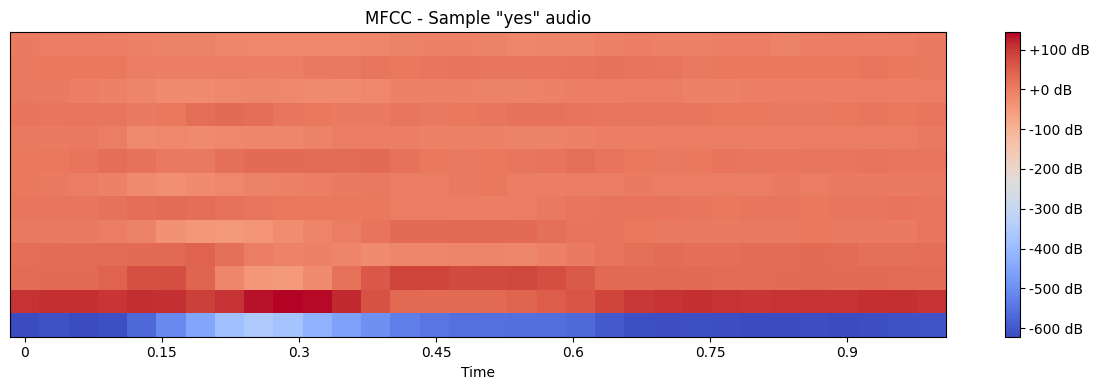

MFCC shape: (13, 32)


In [4]:
# Visualize MFCC for a sample audio file
sample_file = list((data_dir / 'yes').glob('*.wav'))[0]
audio, sr = librosa.load(sample_file, sr=SAMPLE_RATE)
mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC)

plt.figure(figsize=(12, 4))
librosa.display.specshow(mfcc, x_axis='time', sr=sr, hop_length=HOP_LENGTH)
plt.colorbar(format='%+2.0f dB')
plt.title(f'MFCC - Sample "yes" audio')
plt.tight_layout()
plt.savefig('figures/mfcc_example.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"MFCC shape: {mfcc.shape}")


In [5]:
# Extract features from all audio files
X = []  # Features
y = []  # Labels

print("Extracting MFCC features from all audio files...")
for command in tqdm(commands):
    command_dir = data_dir / command
    for audio_file in command_dir.glob('*.wav'):
        features = extract_mfcc(str(audio_file))
        if features is not None:
            X.append(features)
            y.append(command)

X = np.array(X)
y = np.array(y)

print(f"\nFeature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Feature vector length: {X.shape[1]} (13 MFCC + 13 delta + 13 delta-delta)")


Extracting MFCC features from all audio files...


100%|██████████| 8/8 [00:28<00:00,  3.61s/it]


Feature matrix shape: (8000, 39)
Labels shape: (8000,)
Feature vector length: 39 (13 MFCC + 13 delta + 13 delta-delta)


## 4. Prepare Data for Training


In [6]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f"Classes: {label_encoder.classes_}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=SEED, stratify=y_encoded
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Classes: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']
Training set size: 6400
Test set size: 1600


In [7]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")


Features scaled using StandardScaler


## 5. Train Traditional ML Models


In [8]:
# Dictionary to store results
results = {}

# Define models to train
models = {
    'SVM (RBF)': SVC(kernel='rbf', random_state=SEED),
    'SVM (Linear)': SVC(kernel='linear', random_state=SEED),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=SEED),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
}


In [9]:
# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    print(f"{name} Test Accuracy: {accuracy:.4f}")



Training SVM (RBF)...
SVM (RBF) Test Accuracy: 0.5200

Training SVM (Linear)...
SVM (Linear) Test Accuracy: 0.4144

Training Random Forest...
Random Forest Test Accuracy: 0.4594

Training KNN (k=5)...
KNN (k=5) Test Accuracy: 0.3688


## 6. Evaluate Best Model


In [10]:
# Find best model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"Best model: {best_model_name} with accuracy: {results[best_model_name]:.4f}")

# Get predictions from best model
y_pred_best = best_model.predict(X_test_scaled)


Best model: SVM (RBF) with accuracy: 0.5200


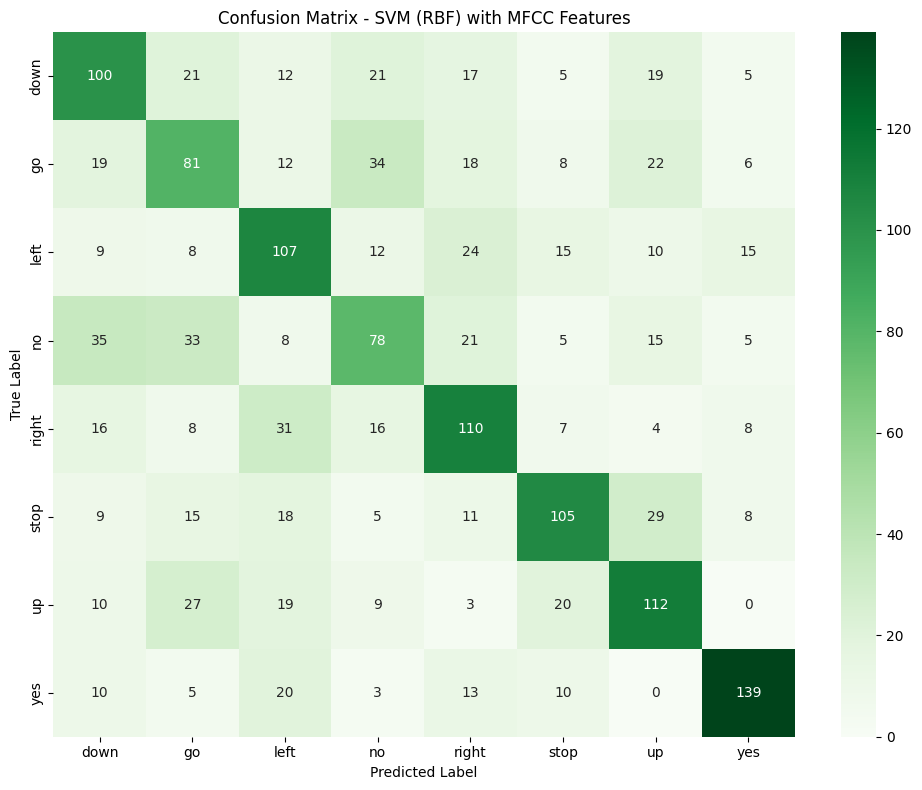

In [11]:
# Confusion matrix for best model
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Greens',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix - {best_model_name} with MFCC Features')
plt.tight_layout()
plt.savefig('figures/confusion_matrix_mfcc.png', dpi=150, bbox_inches='tight')
plt.show()


In [12]:
# Classification report
print(f"\nClassification Report - {best_model_name}:")
print("=" * 60)
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))



Classification Report - SVM (RBF):
              precision    recall  f1-score   support

        down       0.48      0.50      0.49       200
          go       0.41      0.41      0.41       200
        left       0.47      0.54      0.50       200
          no       0.44      0.39      0.41       200
       right       0.51      0.55      0.53       200
        stop       0.60      0.53      0.56       200
          up       0.53      0.56      0.55       200
         yes       0.75      0.69      0.72       200

    accuracy                           0.52      1600
   macro avg       0.52      0.52      0.52      1600
weighted avg       0.52      0.52      0.52      1600



## 7. Compare All Models


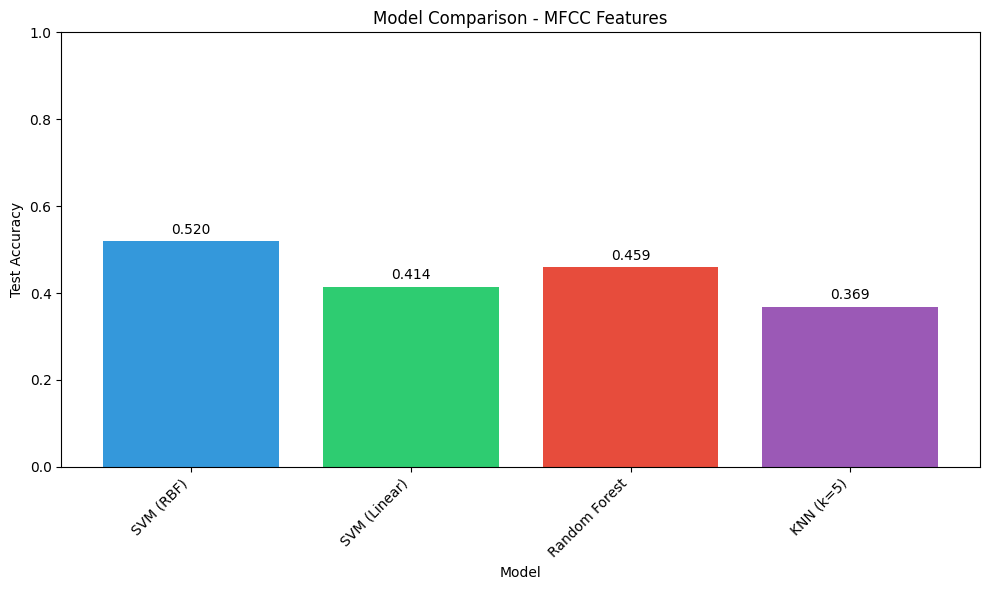

In [13]:
# Plot comparison of all models
plt.figure(figsize=(10, 6))
model_names = list(results.keys())
accuracies = list(results.values())

bars = plt.bar(model_names, accuracies, color=['#3498db', '#2ecc71', '#e74c3c', '#9b59b6'])
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Model Comparison - MFCC Features')
plt.ylim(0, 1)

# Add accuracy labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('figures/model_comparison_mfcc.png', dpi=150, bbox_inches='tight')
plt.show()


In [14]:
# Summary table
print("\n" + "=" * 50)
print("TRADITIONAL ML MODELS RESULTS (MFCC Features)")
print("=" * 50)
print(f"{'Model':<20} {'Test Accuracy':<15}")
print("-" * 35)
for name, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name:<20} {acc:.4f}")
print("-" * 35)
print(f"\nBest Model: {best_model_name}")
print(f"Feature Type: MFCC (13 coefficients + delta + delta-delta = 39 features)")



TRADITIONAL ML MODELS RESULTS (MFCC Features)
Model                Test Accuracy  
-----------------------------------
SVM (RBF)            0.5200
Random Forest        0.4594
SVM (Linear)         0.4144
KNN (k=5)            0.3688
-----------------------------------

Best Model: SVM (RBF)
Feature Type: MFCC (13 coefficients + delta + delta-delta = 39 features)


## 8. Summary and Comparison with Baseline CNN

### Results Summary
This notebook evaluated traditional ML models using MFCC features:
- **Feature Extraction**: 13 MFCCs + 13 delta + 13 delta-delta = 39 features per audio sample
- **Models Tested**: SVM (RBF & Linear), Random Forest, KNN

### Comparison with Baseline CNN
| Approach | Features | Model | Accuracy |
|----------|----------|-------|----------|
| Baseline CNN | Spectrogram (STFT) | CNN | See baseline_cnn_model.ipynb |
| Traditional ML | MFCC | Best model above | See results above |

### Key Differences
1. **Feature Engineering**: CNN learns features automatically from spectrograms; traditional ML requires hand-crafted MFCC features
2. **Model Complexity**: CNN has more parameters; traditional ML models are simpler
3. **Training Time**: Traditional ML typically trains faster
4. **Interpretability**: MFCC features are more interpretable than learned CNN features
